In [2]:
pip install ultralytics pandas opencv-python pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 17.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from ultralytics import YOLO
print("YOLOv8 installed successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8 installed successfully!


# Spliting the Dataset

In [5]:
import os

# Define input directories
input_base_dir = "/kaggle/input/cardamagedetection/CarDD_COCO/"
splits = ["train2017", "val2017", "test2017"]

# Check the contents of each split
for split in splits:
     split_dir = os.path.join(input_base_dir, split)
     if os.path.exists(split_dir):
         num_images = len([f for f in os.listdir(split_dir) if f.endswith(".jpg")])
         print(f"Number of images in {split_dir}: {num_images}")
         print(f"Sample images: {os.listdir(split_dir)[:5]}")
     else:
         print(f"Directory {split_dir} does not exist!")

Number of images in /kaggle/input/cardamagedetection/CarDD_COCO/train2017: 2816
Sample images: ['000304.jpg', '001229.jpg', '001989.jpg', '000780.jpg', '003113.jpg']
Number of images in /kaggle/input/cardamagedetection/CarDD_COCO/val2017: 810
Sample images: ['001940.jpg', '000748.jpg', '000857.jpg', '000853.jpg', '003479.jpg']
Number of images in /kaggle/input/cardamagedetection/CarDD_COCO/test2017: 374
Sample images: ['000875.jpg', '001071.jpg', '001506.jpg', '002056.jpg', '003831.jpg']


In [6]:
import os
import shutil

# Define paths
input_base_dir = "/kaggle/input/cardamagedetection/CarDD_COCO/"
output_base_dir = "/kaggle/working/CarDD/images/"
splits = {"train2017": "train", "val2017": "val", "test2017": "test"}

# Create output directories and copy images
for input_split, output_split in splits.items():
    input_dir = os.path.join(input_base_dir, input_split)
    output_dir = os.path.join(output_base_dir, output_split)
    
    # Create the output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Copy images
    if os.path.exists(input_dir):
        for img in os.listdir(input_dir):
            if img.endswith(".jpg"):
                shutil.copy(os.path.join(input_dir, img), os.path.join(output_dir, img))
        print(f"Copied images to {output_dir}: {len(os.listdir(output_dir))} images")
    else:
        print(f"Input directory {input_dir} does not exist!")

# Verify the copy
for split in splits.values():
    split_dir = os.path.join(output_base_dir, split)
    print(f"Number of images in {split_dir}: {len(os.listdir(split_dir))}")
    print(f"Sample images: {os.listdir(split_dir)[:5]}")

Copied images to /kaggle/working/CarDD/images/train: 2816 images
Copied images to /kaggle/working/CarDD/images/val: 810 images
Copied images to /kaggle/working/CarDD/images/test: 374 images
Number of images in /kaggle/working/CarDD/images/train: 2816
Sample images: ['000681.jpg', '002201.jpg', '002227.jpg', '003571.jpg', '000829.jpg']
Number of images in /kaggle/working/CarDD/images/val: 810
Sample images: ['001379.jpg', '001400.jpg', '003521.jpg', '000105.jpg', '002057.jpg']
Number of images in /kaggle/working/CarDD/images/test: 374
Sample images: ['001993.jpg', '003748.jpg', '000965.jpg', '003554.jpg', '000237.jpg']


# Data Checking

In [7]:
import os
import shutil

# Define paths
input_dataset_dir = "/kaggle/input/cardamagedetection/CarDD_COCO/"
working_dir = "/kaggle/working/yolo_labels"
images_dir = os.path.join(working_dir, "images")
labels_dir = os.path.join(working_dir, "labels")

# Create directories
os.makedirs(os.path.join(images_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(images_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(images_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(labels_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(labels_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(labels_dir, "test"), exist_ok=True)

# Copy images
for split in ["train2017", "val2017", "test2017"]:
    split_name = split.replace("2017", "")  # e.g., "train2017" -> "train"
    src_dir = os.path.join(input_dataset_dir, split)
    dst_dir = os.path.join(images_dir, split_name)
    for img in os.listdir(src_dir):
        if img.endswith(".jpg"):
            shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))

# Verify the copy
for split in ["train", "val", "test"]:
    print(f"Number of images in {split}: {len(os.listdir(os.path.join(images_dir, split)))}")

Number of images in train: 2816
Number of images in val: 810
Number of images in test: 374


In [8]:
import json
import os
from pathlib import Path

# Define paths
annotation_dir = "/kaggle/input/cardamagedetection/CarDD_COCO/annotations"
output_labels_base_dir = "/kaggle/working/CarDD/labels/"
splits = {"train2017": "train", "val2017": "val", "test2017": "test"}

# Class mapping
class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

# Convert COCO to YOLO for each split
for input_split, output_split in splits.items():
    output_labels_dir = os.path.join(output_labels_base_dir, output_split)
    os.makedirs(output_labels_dir, exist_ok=True)
    
    # Load COCO JSON
    with open(os.path.join(annotation_dir, f"instances_{input_split}.json"), "r") as f:
        coco_data = json.load(f)

    # Create a dictionary of image IDs to file names and dimensions
    image_dict = {}
    for img in coco_data["images"]:
        image_dict[img["id"]] = {
            "file_name": img["file_name"],
            "width": img["width"],
            "height": img["height"]
        }

    # Process annotations
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in image_dict:
            continue

        img_info = image_dict[image_id]
        file_name = img_info["file_name"]
        width, height = img_info["width"], img_info["height"]

        # Convert bounding box to YOLO format
        bbox = ann["bbox"]  # [x_min, y_min, width, height]
        x_min, y_min, bbox_w, bbox_h = bbox
        x_center = (x_min + bbox_w / 2) / width
        y_center = (y_min + bbox_h / 2) / height
        bbox_w_norm = bbox_w / width
        bbox_h_norm = bbox_h / height

        # Map class ID
        coco_class_id = ann["category_id"]
        yolo_class_id = class_mapping.get(coco_class_id, -1)
        if yolo_class_id == -1:
            continue

        # Write to label file
        label_file = os.path.join(output_labels_dir, f"{Path(file_name).stem}.txt")
        with open(label_file, "a") as f:
            f.write(f"{yolo_class_id} {x_center} {y_center} {bbox_w_norm} {bbox_h_norm}\n")

    print(f"Generated labels for {output_split}: {len(os.listdir(output_labels_dir))} labels")

Generated labels for train: 2816 labels
Generated labels for val: 810 labels
Generated labels for test: 374 labels


In [9]:
# Verify images and labels for each split
for split in splits.values():
    images_dir = os.path.join(output_base_dir, split)
    labels_dir = os.path.join(output_labels_base_dir, split)

    images = set([f.split(".")[0] for f in os.listdir(images_dir) if f.endswith(".jpg")])
    labels = set([f.split(".")[0] for f in os.listdir(labels_dir) if f.endswith(".txt")])

    print(f"\nSplit: {split}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

    images_without_labels = images - labels
    labels_without_images = labels - images

    print(f"Images without labels: {len(images_without_labels)}")
    print(f"Labels without images: {len(labels_without_images)}")

    if images_without_labels:
        print("Sample images without labels:", list(images_without_labels)[:5])
    if labels_without_images:
        print("Sample labels without images:", list(labels_without_images)[:5])


Split: train
Number of images: 2816
Number of labels: 2816
Images without labels: 0
Labels without images: 0

Split: val
Number of images: 810
Number of labels: 810
Images without labels: 0
Labels without images: 0

Split: test
Number of images: 374
Number of labels: 374
Images without labels: 0
Labels without images: 0


# Create YML File

In [10]:
# Recreate dataset.yaml to be safe
with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write("""
train: /kaggle/working/CarDD/images/train
val: /kaggle/working/CarDD/images/val
test: /kaggle/working/CarDD/images/test

nc: 6
names: ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']
""")

# Verify the contents
with open("/kaggle/working/dataset.yaml", "r") as f:
    print(f.read())


train: /kaggle/working/CarDD/images/train
val: /kaggle/working/CarDD/images/val
test: /kaggle/working/CarDD/images/test

nc: 6
names: ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']



# Model Training

In [11]:
import os
from ultralytics import YOLO
import torch

# Set environment variable to manage memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Verify GPU availability
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Verify dataset directories before training
for split in ["train", "val", "test"]:
    images_dir = f"/kaggle/working/CarDD/images/{split}"
    labels_dir = f"/kaggle/working/CarDD/labels/{split}"
    print(f"{split} - Images: {len(os.listdir(images_dir))} | Labels: {len(os.listdir(labels_dir))}")

# Load the YOLOv8m model
model = YOLO("yolov8m.pt")

# Fine-tune the model
try:
    model.train(
        data="/kaggle/working/dataset.yaml",
        epochs=120,
        imgsz=640,           # Reduced from 1024 to 640
        batch=16,            # Reduced from 32 to 16 (adjust if needed)
        name="car_damage_yolov8m_finetune_v2",
        project="/kaggle/working/models",
        device=0 if torch.cuda.is_available() else "cpu",
        workers=4,
        lr0=0.001,
        lrf=0.01,
        cos_lr=True,
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=5.0,
        patience=20,
        box=10.0,
        cls=3.0,
        dfl=1.5,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=15.0,
        translate=0.3,
        scale=0.7,
        flipud=0.5,
        fliplr=0.5,
        mosaic=0.5,
        mixup=0.1
    )
    print("Fine-tuning completed!")
except Exception as e:
    print(f"An error occurred during fine-tuning: {e}")

GPU Available: True
GPU Name: Tesla T4
train - Images: 2816 | Labels: 2816
val - Images: 810 | Labels: 810
test - Images: 374 | Labels: 374


100%|██████████| 49.7M/49.7M [00:00<00:00, 215MB/s]


Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/dataset.yaml, epochs=120, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=/kaggle/working/models, name=car_damage_yolov8m_finetune_v2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4022.5±860.2 MB/s, size: 771.1 KB)


train: Scanning /kaggle/working/CarDD/labels/train... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:02<00:00, 1023.71it/s]


train: New cache created: /kaggle/working/CarDD/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1699.2±1360.6 MB/s, size: 618.6 KB)


val: Scanning /kaggle/working/CarDD/labels/val... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1014.92it/s]


val: New cache created: /kaggle/working/CarDD/labels/val.cache
Plotting labels to /kaggle/working/models/car_damage_yolov8m_finetune_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/models/car_damage_yolov8m_finetune_v2
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      5.68G      2.404      18.61      1.988         53        640: 100%|██████████| 176/176 [01:31<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]

                   all        810       1744      0.495      0.403      0.431       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      5.74G      2.471      15.14      2.013         72        640: 100%|██████████| 176/176 [01:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.363      0.388      0.298      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120       5.8G      2.592      15.77      2.113         38        640: 100%|██████████| 176/176 [01:39<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.64it/s]


                   all        810       1744      0.437      0.337       0.35      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      5.82G      2.566      15.49      2.098         49        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.64it/s]


                   all        810       1744      0.459      0.425      0.391      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      5.82G      2.541      15.47      2.087         43        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


                   all        810       1744      0.771       0.27      0.295      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      5.82G      2.527       15.3      2.075         78        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744      0.317      0.328      0.318      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      5.82G      2.476      14.84      2.046         50        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


                   all        810       1744      0.535      0.423      0.444      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      5.82G      2.434      14.43      2.013         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.349      0.428      0.404      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      5.82G      2.412      14.18      1.996         75        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


                   all        810       1744      0.598      0.441      0.448      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      5.82G      2.376       13.8      1.978         34        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.586      0.465      0.493      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      5.82G      2.333       13.5       1.94         58        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744      0.531      0.475        0.5      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      5.82G      2.333      13.39      1.942         62        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.65it/s]


                   all        810       1744      0.657      0.496      0.515       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      5.82G      2.322      13.14      1.938         66        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744      0.627      0.481       0.51      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      5.82G      2.312      13.06      1.919         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744      0.549      0.516       0.52      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      5.84G      2.297       12.8      1.902         51        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.65it/s]


                   all        810       1744      0.668      0.495      0.528       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      5.84G      2.257      12.57      1.884         61        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


                   all        810       1744      0.555       0.53      0.526      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      5.84G      2.242      12.31      1.863         47        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744      0.551       0.56      0.559      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      5.84G      2.211      12.07      1.854         61        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


                   all        810       1744      0.576      0.571      0.568      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      5.84G       2.24      12.13      1.864         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


                   all        810       1744      0.568      0.555      0.571      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      5.84G      2.209      12.07      1.841         58        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


                   all        810       1744      0.597       0.57      0.579      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      5.84G        2.2      11.72      1.839         66        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744      0.589      0.545      0.563      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      5.84G      2.195      11.68      1.844         46        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


                   all        810       1744      0.548      0.554      0.557      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      5.84G      2.179      11.72      1.842         56        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


                   all        810       1744      0.576      0.583        0.6      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      5.84G      2.172      11.69      1.822         54        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.581      0.566       0.59      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      5.84G      2.159      11.43      1.819         45        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744      0.643      0.551      0.584      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      5.84G      2.161      11.24      1.804         55        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


                   all        810       1744       0.56      0.579      0.586      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      5.84G      2.171      11.38      1.824         44        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744      0.594      0.605      0.612      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      5.84G      2.132      11.17      1.791         56        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.624      0.591      0.614       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      5.84G       2.14      11.13      1.797         55        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.591      0.602      0.605       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      5.84G      2.092      10.91      1.794         48        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


                   all        810       1744      0.653      0.596      0.621      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      5.84G      2.112      10.93      1.788         48        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.597      0.618      0.615      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      5.84G      2.124      10.86      1.784         85        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]


                   all        810       1744      0.654      0.607       0.63      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      5.84G      2.064      10.54      1.751         80        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744      0.645      0.605      0.616       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      5.84G      2.103      10.69      1.779         67        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.605      0.604      0.632      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      5.84G      2.057      10.51      1.754         36        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


                   all        810       1744      0.626      0.625      0.643      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      5.84G      2.085      10.49      1.765         54        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]


                   all        810       1744      0.653      0.614      0.633      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      5.84G      2.071       10.4      1.755         54        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.658      0.598      0.637      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      5.84G       2.07       10.2      1.752         79        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


                   all        810       1744      0.645      0.609      0.632      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      5.84G      2.071      10.34      1.761         38        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.652      0.636      0.643      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      5.84G      2.053      10.25      1.754         43        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


                   all        810       1744      0.691      0.617      0.652      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      5.84G      2.043      9.999      1.731         32        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.674      0.621       0.65      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      5.84G      2.048      9.939      1.735         56        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


                   all        810       1744       0.62      0.643      0.648      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      5.84G       2.02      9.942      1.714         83        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.674      0.621      0.654      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      5.84G      2.022      9.888      1.717         42        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]


                   all        810       1744      0.688      0.614       0.66      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      5.84G      2.021      9.902      1.727         63        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744       0.69      0.615      0.658      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      5.84G      2.046      9.819      1.718         50        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


                   all        810       1744      0.689      0.622      0.646      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      5.84G      2.009      9.719      1.696         71        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


                   all        810       1744      0.702       0.63      0.672      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      5.84G      1.986      9.602      1.694         63        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744       0.68      0.648      0.683       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      5.84G      1.998      9.704      1.696         47        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


                   all        810       1744       0.68      0.631      0.665      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      5.84G      1.973      9.418      1.673         61        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.708      0.665      0.698      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      5.84G      1.974      9.291      1.682         41        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.707      0.624      0.659      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      5.84G      1.972      9.454      1.686         76        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.743      0.638      0.691      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      5.84G      1.973      9.298      1.683         52        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744      0.717      0.641      0.684      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      5.84G       1.95      9.296       1.68         69        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


                   all        810       1744      0.696      0.663      0.682      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      5.84G       1.92      9.013      1.665         74        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]

                   all        810       1744      0.713      0.668      0.699      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      5.84G      1.922      8.955      1.658         42        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


                   all        810       1744      0.706      0.655      0.689      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      5.84G      1.944      8.941      1.669         67        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.755      0.643      0.701      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      5.84G      1.919      8.823      1.651         38        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.736      0.663      0.696      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      5.84G      1.916      8.805      1.641         85        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.724      0.673      0.708      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      5.84G      1.917      8.676      1.649         54        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.721      0.672      0.705      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      5.84G      1.906      8.652       1.64         62        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


                   all        810       1744      0.718      0.673      0.711      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      5.84G      1.889      8.554      1.625         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.724      0.672      0.708      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      5.84G      1.881      8.461       1.63         71        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]

                   all        810       1744      0.741      0.674      0.718        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      5.84G      1.883      8.499      1.624         50        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.714      0.663      0.701      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      5.84G      1.875       8.47      1.618         51        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


                   all        810       1744       0.75      0.661      0.705      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      5.84G      1.863      8.248      1.612         47        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.761      0.674      0.721      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      5.84G      1.849      8.179      1.607         48        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.734      0.676      0.713        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      5.84G      1.857      8.229       1.62         81        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.64it/s]


                   all        810       1744      0.722      0.694      0.716      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      5.84G      1.847       8.07      1.606         53        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


                   all        810       1744      0.756      0.683      0.724      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      5.84G      1.857      8.094      1.613         79        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.701      0.692      0.713      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      5.84G      1.836      7.981      1.601         43        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.722      0.682      0.714      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      5.84G      1.837        7.9      1.597         74        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]


                   all        810       1744      0.717        0.7      0.717      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      5.84G       1.81      7.786      1.591         56        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.708       0.71      0.725      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      5.84G      1.828      7.702      1.588         74        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all        810       1744      0.736      0.696      0.726      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      5.84G       1.81      7.661      1.576        103        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.67it/s]


                   all        810       1744       0.74      0.692       0.72      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      5.84G      1.814      7.735      1.584         62        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.754      0.697      0.736       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      5.84G      1.806      7.492       1.58         50        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.737      0.679      0.718      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      5.84G      1.788      7.464      1.567         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.68it/s]

                   all        810       1744      0.745      0.708      0.734      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      5.84G      1.781      7.548      1.557         44        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.754      0.692      0.727      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      5.84G      1.783      7.411      1.566         41        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.743      0.702      0.734      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      5.84G      1.769      7.208      1.553         77        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.742      0.702      0.731      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      5.84G      1.757      7.179      1.548         63        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]

                   all        810       1744      0.732      0.704      0.729       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      5.84G      1.774       7.16      1.544         73        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all        810       1744      0.768        0.7      0.741      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      5.84G      1.761      7.107      1.542         60        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.791      0.683      0.738      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      5.84G      1.748      6.948      1.523         47        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.772      0.698      0.741      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      5.84G      1.751      6.981      1.538         73        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all        810       1744      0.777      0.704      0.747      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      5.84G       1.72      6.903      1.517         69        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


                   all        810       1744      0.757      0.702      0.739      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.84G      1.713       6.79      1.522         36        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


                   all        810       1744      0.766      0.704      0.738      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.84G      1.712      6.822      1.522         57        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744       0.77      0.706      0.742       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      5.84G      1.744      6.802      1.521         72        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.786      0.698      0.739      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.84G      1.716      6.783      1.522         57        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.755        0.7      0.743       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.84G      1.723       6.81      1.526         53        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.798      0.689      0.748      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      5.84G      1.699      6.522      1.509         91        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744       0.76      0.703      0.751      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.84G      1.703      6.644      1.518         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.788        0.7      0.746      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.84G      1.685      6.485      1.496         63        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]

                   all        810       1744      0.758      0.716      0.745      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      5.84G      1.702      6.666       1.51         60        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.776      0.708      0.748      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.84G       1.71      6.637      1.508         69        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.775      0.708      0.749       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.84G      1.671      6.319      1.494         59        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.768      0.706      0.745      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      5.84G      1.688      6.418      1.498         74        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all        810       1744      0.762      0.718      0.747      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      5.84G      1.678      6.358      1.495         84        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.791        0.7       0.75       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      5.84G      1.667      6.192      1.477         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.795      0.702      0.757       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      5.84G      1.663      6.178      1.474         65        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.785      0.705      0.757      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      5.84G      1.627      6.124      1.464         73        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]

                   all        810       1744      0.779      0.712      0.757      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      5.84G      1.644      6.073       1.47         49        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.766      0.717      0.756       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      5.84G      1.656      6.178       1.47         55        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.797      0.697      0.754      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      5.84G      1.655      6.149      1.467         47        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.774      0.709      0.754       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      5.84G       1.63      6.055      1.459         74        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.776      0.707      0.752      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      5.84G      1.652       6.14      1.466         67        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]

                   all        810       1744      0.779       0.71      0.752      0.566


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.84G      1.526      4.771      1.413         32        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.771      0.704       0.75      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.84G      1.529       4.79       1.42         50        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        810       1744      0.769      0.708       0.75      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      5.84G      1.509      4.742      1.411         33        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.772      0.704      0.752      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      5.84G      1.506      4.645      1.408         38        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


                   all        810       1744        0.8      0.694      0.756      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      5.84G      1.519      4.716      1.421         20        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

                   all        810       1744      0.793      0.699      0.754      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      5.84G      1.505       4.64      1.398         28        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all        810       1744      0.789      0.706      0.755      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      5.84G      1.515      4.628      1.408         35        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all        810       1744      0.785      0.705      0.755      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      5.84G      1.491      4.588        1.4         34        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

                   all        810       1744      0.804        0.7      0.755      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      5.84G      1.512      4.657      1.403         23        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all        810       1744      0.792      0.703      0.756      0.571



120 epochs completed in 3.633 hours.
Optimizer stripped from /kaggle/working/models/car_damage_yolov8m_finetune_v2/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/models/car_damage_yolov8m_finetune_v2/weights/best.pt, 52.0MB

Validating /kaggle/working/models/car_damage_yolov8m_finetune_v2/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.52it/s]


                   all        810       1744      0.792      0.706      0.755      0.572
                  dent        352        501      0.684      0.527      0.599      0.318
               scratch        431        728      0.629      0.556      0.573      0.325
                 crack        122        177       0.69      0.441      0.503      0.229
         glass shatter        134        135      0.962      0.978      0.992      0.922
           lamp broken        139        141      0.846      0.865      0.911      0.776
             tire flat         59         62       0.94      0.871      0.955      0.861


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 7.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/models/car_damage_yolov8m_finetune_v2
Fine-tuning completed!


# Model Validation

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO("/kaggle/working/models/car_damage_yolov8m_finetune_v2/weights/best.pt")

# Evaluate on the test set
try:
    metrics = model.val(data="/kaggle/working/dataset.yaml", split="test")
    print("Test set evaluation metrics:", metrics.box)

    # Extract metrics
    precision = metrics.box.map  # Mean Average Precision
    recall = metrics.box.rec  # Recall
    map50 = metrics.box.map50  # mAP@0.5
    map50_95 = metrics.box.map75  # mAP@0.5:0.95 (approximated)
    conf_matrix = metrics.confusion_matrix.matrix  # Confusion matrix

    # Calculate False Positives (FP) and approximate FP Rate
    # FP is the off-diagonal sum of predicted classes not matching ground truth
    fp = np.sum(conf_matrix) - np.trace(conf_matrix)
    tn = 0  # True Negatives are not directly available; approximated as (total possible - TP - FP - FN)
    fn = np.sum(metrics.box.fn)  # False Negatives
    tp = np.sum(metrics.box.tp)  # True Positives
    total_possible = len(metrics.data) * 6  # Assuming 6 classes per image (max possible detections)
    tn = total_possible - (tp + fp + fn) if total_possible > (tp + fp + fn) else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Positive Rate: {fp_rate:.3f}")

    # AUC vs. IoU (using mAP at different IoU thresholds)
    iou_thresholds = np.arange(0.5, 0.96, 0.05)  # IoU from 0.5 to 0.95
    map_values = [metrics.box.get_map(iou) for iou in iou_thresholds]
    auc_iou = np.trapz(map_values, iou_thresholds) / (0.95 - 0.5)  # Approximate AUC
    print(f"AUC vs. IoU: {auc_iou:.3f}")

    # Plot AUC vs. IoU
    plt.figure(figsize=(8, 5))
    plt.plot(iou_thresholds, map_values, marker="o", linestyle="-", color="b")
    plt.title("mAP vs. IoU Threshold")
    plt.xlabel("IoU Threshold")
    plt.ylabel("mAP")
    plt.grid()
    plt.show()

    # AUC Score (using mAP50-95 as a proxy)
    auc_score = map50_95  # mAP50-95 is the standard AUC-like metric for detection
    print(f"AUC Score (mAP50-95): {auc_score:.3f}")

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3134.0±367.3 MB/s, size: 833.9 KB)


val: Scanning /kaggle/working/CarDD/labels/test.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


                   all        374        785      0.767      0.714      0.731      0.551
                  dent        157        236      0.604      0.585      0.573      0.316
               scratch        183        307      0.594      0.603      0.625      0.333
                 crack         48         70      0.595      0.443      0.434      0.207
         glass shatter         71         71      0.951      0.972       0.99      0.908
           lamp broken         65         69       0.86      0.812      0.851      0.699
             tire flat         31         32          1      0.869      0.914      0.846


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 17.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
Test set evaluation metrics: ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.57326,     0.54021,     0.50366,     0.42905,     0.36504,      0.2757,     0.22431,     0.15879,    0.076611,    0.010923],
       [    0.62461,     0.57748,     0.53721,     0.46505,     0.39175,     0.33064,     0.23652,     0.11732,     0.04385,   0.0016171],
       [    0.43442,     0.41492,     0.40068,      0.3464,     0.21616,       0.178,    0.065775,   0.0085068,  0.00034727,           0],
       [    0.99002,     0.99002,     0.99002,     0.99002,     0.98385,     0.98385,     0.98385,     0.90615,     0.81252,     0.45267],
       [    0.85143,     0.85143,     0.83903,     0.83903,     0.82315,     0.80381,     0.75347,     0.65304,     0.40675,     0.17031],
       [    0.91394,     0.91394,     0.91394,     0.91394,     0.91394,     0.91394,     0.91

# Model Prediction

In [14]:
# Make predictions on a test image
try:
    image_path = "/kaggle/working/CarDD/images/test/000012.jpg"
    results = model.predict(
        source=image_path,
        save=True,
        save_txt=True,
        project="/kaggle/working/predictions",
        name="predict"
    )
    for result in results:
        print(result.boxes)
except Exception as e:
    print(f"An error occurred during prediction: {e}")


image 1/1 /kaggle/working/CarDD/images/test/000012.jpg: 448x640 1 lamp broken, 1 tire flat, 27.4ms
Speed: 2.4ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/predictions/predict2
1 label saved to /kaggle/working/predictions/predict2/labels
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 4.], device='cuda:0')
conf: tensor([0.9260, 0.3408], device='cuda:0')
data: tensor([[2.7089e+01, 2.1343e+02, 3.4891e+02, 5.5841e+02, 9.2597e-01, 5.0000e+00],
        [8.3718e+02, 1.1053e+02, 9.1476e+02, 1.6857e+02, 3.4085e-01, 4.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (667, 1000)
shape: torch.Size([2, 6])
xywh: tensor([[187.9994, 385.9194, 321.8211, 344.9754],
        [875.9703, 139.5518,  77.5807,  58.0387]], device='cuda:0')
xywhn: tensor([[0.1880, 0.5786, 0.3218, 0.5172],
        [0.8760, 0.2092, 0.0776, 0.0870]], device='cuda:0')
xyxy: tensor([[ 27.0888, 213.4317, 348.9099, 55

In [15]:
import os
import random
from ultralytics import YOLO

# Load the trained model (ensure the path matches your trained model)
model = YOLO("/kaggle/working/models/car_damage_yolov8m_finetune_v2/weights/best.pt")

# Define the test images directory
test_images_dir = "/kaggle/working/CarDD/images/test/"

# Get a list of all test images
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# Randomly select 5 images
random_images = random.sample(test_images, 5)
print("Selected images:", random_images)

# Make predictions on each test image
for img_name in random_images:
    image_path = os.path.join(test_images_dir, img_name)
    print(f"\nPredicting on {img_name}...")
    
    try:
        # Make predictions
        results = model.predict(
            source=image_path,
            save=True,           # Save the image with bounding boxes
            save_txt=True,       # Save the predictions as a .txt file
            project="/kaggle/working/predictions",
            name="predict",
            conf=0.1,            # Confidence threshold (lowered to capture more detections)
            iou=0.45             # IoU threshold for NMS
        )
        
        # Print the bounding box details
        for result in results:
            print(f"Results for {img_name}:")
            boxes = result.boxes
            if len(boxes) == 0:
                print("No damage detected (confidence threshold: 0.1).")
            else:
                for box in boxes:
                    class_id = int(box.cls[0])
                    class_name = model.names[class_id]
                    confidence = box.conf[0]
                    bbox = box.xywh[0]  # [x_center, y_center, width, height]
                    print(f" - {class_name} (Confidence: {confidence:.2f}) at {bbox}")
    
    except Exception as e:
        print(f"An error occurred during prediction for {img_name}: {e}")

Selected images: ['002567.jpg', '003071.jpg', '001751.jpg', '001633.jpg', '002552.jpg']

Predicting on 002567.jpg...

image 1/1 /kaggle/working/CarDD/images/test/002567.jpg: 448x640 3 scratchs, 28.0ms
Speed: 2.1ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/predictions/predict3
1 label saved to /kaggle/working/predictions/predict3/labels
Results for 002567.jpg:
 - scratch (Confidence: 0.79) at tensor([520.0153, 259.1927, 552.3333, 188.2460], device='cuda:0')
 - scratch (Confidence: 0.53) at tensor([487.8052, 444.2091, 293.9045, 116.3546], device='cuda:0')
 - scratch (Confidence: 0.37) at tensor([763.7933, 424.4344,  90.4138,  97.1649], device='cuda:0')

Predicting on 003071.jpg...

image 1/1 /kaggle/working/CarDD/images/test/003071.jpg: 448x640 1 glass shatter, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/predictions/predic

# Model Visualization

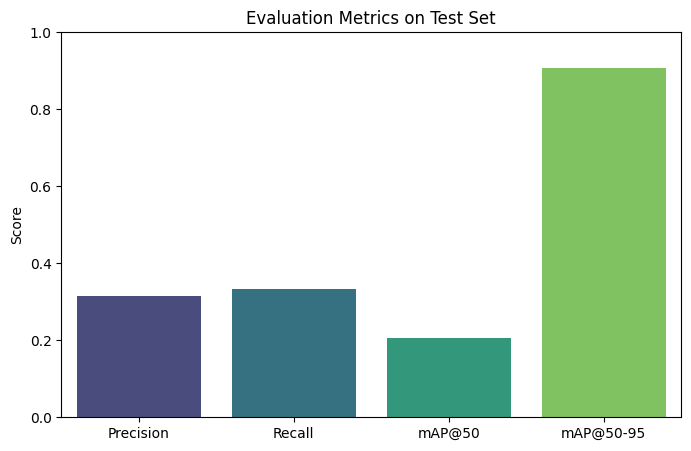

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract values
precision = metrics.box.maps[0]  # Precision
recall = metrics.box.maps[1]  # Recall
map50 = metrics.box.maps[2]  # mAP@50
map50_95 = metrics.box.maps[3]  # mAP@50-95

# Plot Bar Chart
labels = ["Precision", "Recall", "mAP@50", "mAP@50-95"]
values = [precision, recall, map50, map50_95]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Evaluation Metrics on Test Set")
plt.ylabel("Score")
plt.show()


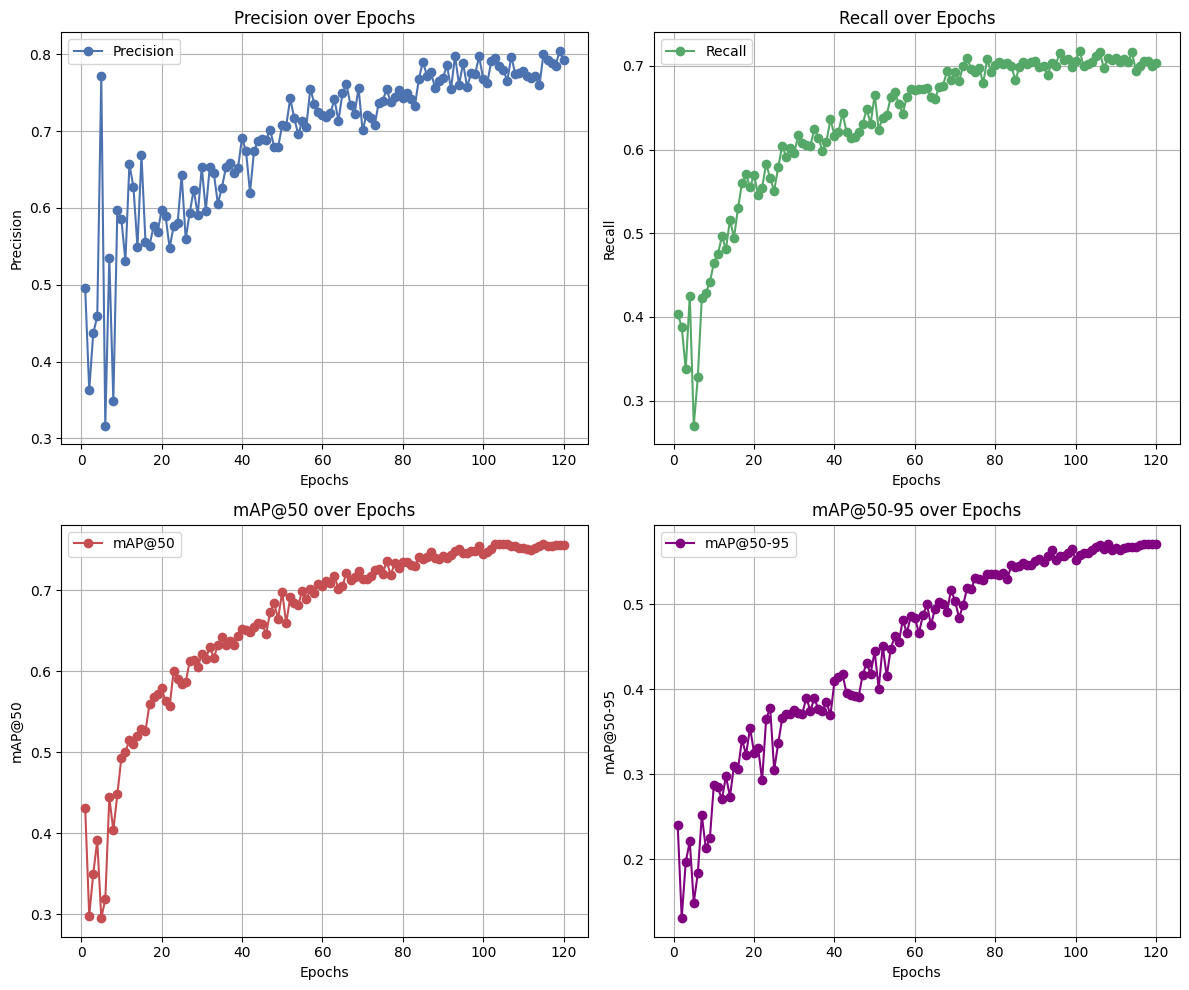

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the results CSV (Change based on your experiment name)
results_csv_path = "/kaggle/working/models/car_damage_yolov8m_finetune_v2/results.csv"

# Check if file exists
if not os.path.exists(results_csv_path):
    print("Error: results.csv not found! Ensure training has completed successfully.")
else:
    # Load training results
    df = pd.read_csv(results_csv_path)

    # Extract values for plotting
    epochs = df["epoch"]
    precision_values = df["metrics/precision(B)"]
    recall_values = df["metrics/recall(B)"]
    map50_values = df["metrics/mAP50(B)"]
    map50_95_values = df["metrics/mAP50-95(B)"]

    # Create subplots for separate line plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Precision Plot
    axs[0, 0].plot(epochs, precision_values, marker="o", linestyle="-", color="b", label="Precision")
    axs[0, 0].set_title("Precision over Epochs")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Precision")
    axs[0, 0].grid()
    axs[0, 0].legend()

    # Recall Plot
    axs[0, 1].plot(epochs, recall_values, marker="o", linestyle="-", color="g", label="Recall")
    axs[0, 1].set_title("Recall over Epochs")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("Recall")
    axs[0, 1].grid()
    axs[0, 1].legend()

    # mAP@50 Plot
    axs[1, 0].plot(epochs, map50_values, marker="o", linestyle="-", color="r", label="mAP@50")
    axs[1, 0].set_title("mAP@50 over Epochs")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("mAP@50")
    axs[1, 0].grid()
    axs[1, 0].legend()

    # mAP@50-95 Plot
    axs[1, 1].plot(epochs, map50_95_values, marker="o", linestyle="-", color="purple", label="mAP@50-95")
    axs[1, 1].set_title("mAP@50-95 over Epochs")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("mAP@50-95")
    axs[1, 1].grid()
    axs[1, 1].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


# Save to Zip File

In [20]:
import shutil

# Define the folders and corresponding zip filenames
folders_to_zip = {
    "/kaggle/working/predictions": "/kaggle/working/predictions.zip",
    "/kaggle/working/models/car_damage_yolov8m_finetune_v2": "/kaggle/working/models/car_damage_yolov8m_finetune_v2.zip"
}

# Zip each folder
for folder, zip_path in folders_to_zip.items():
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder)
    print(f"Zipped: {folder} -> {zip_path}")

print("All folders have been zipped successfully!")

Zipped: /kaggle/working/predictions -> /kaggle/working/predictions.zip
Zipped: /kaggle/working/models/car_damage_yolov8m_finetune_v2 -> /kaggle/working/models/car_damage_yolov8m_finetune_v2.zip
All folders have been zipped successfully!
